<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

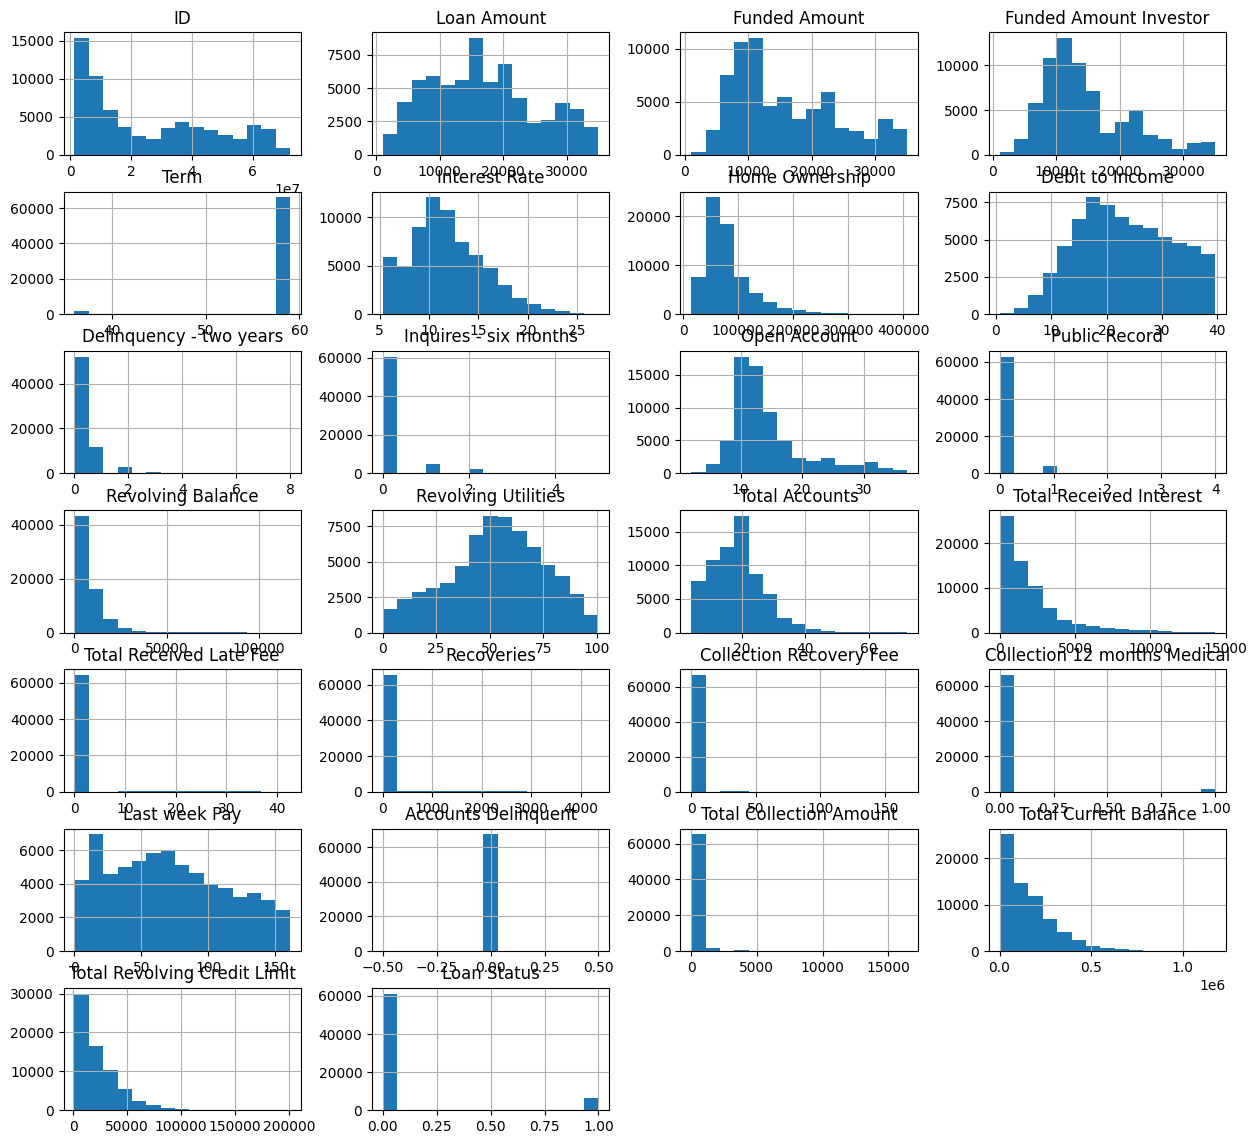

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
import time
import math

# Load the dataset
data = pd.read_csv('train.csv')

# Basic information and summary statistics
print(data.info())
print(data.describe())

# Checking for missing values
print(data.isnull().sum())

# Histograms for numerical features
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
num_cols = len(numerical_columns)
n_rows, n_cols = math.ceil(num_cols / 4), 4  # Adjusting layout dynamically
data[numerical_columns].hist(bins=15, figsize=(15, n_rows*2), layout=(n_rows, n_cols))
plt.show()





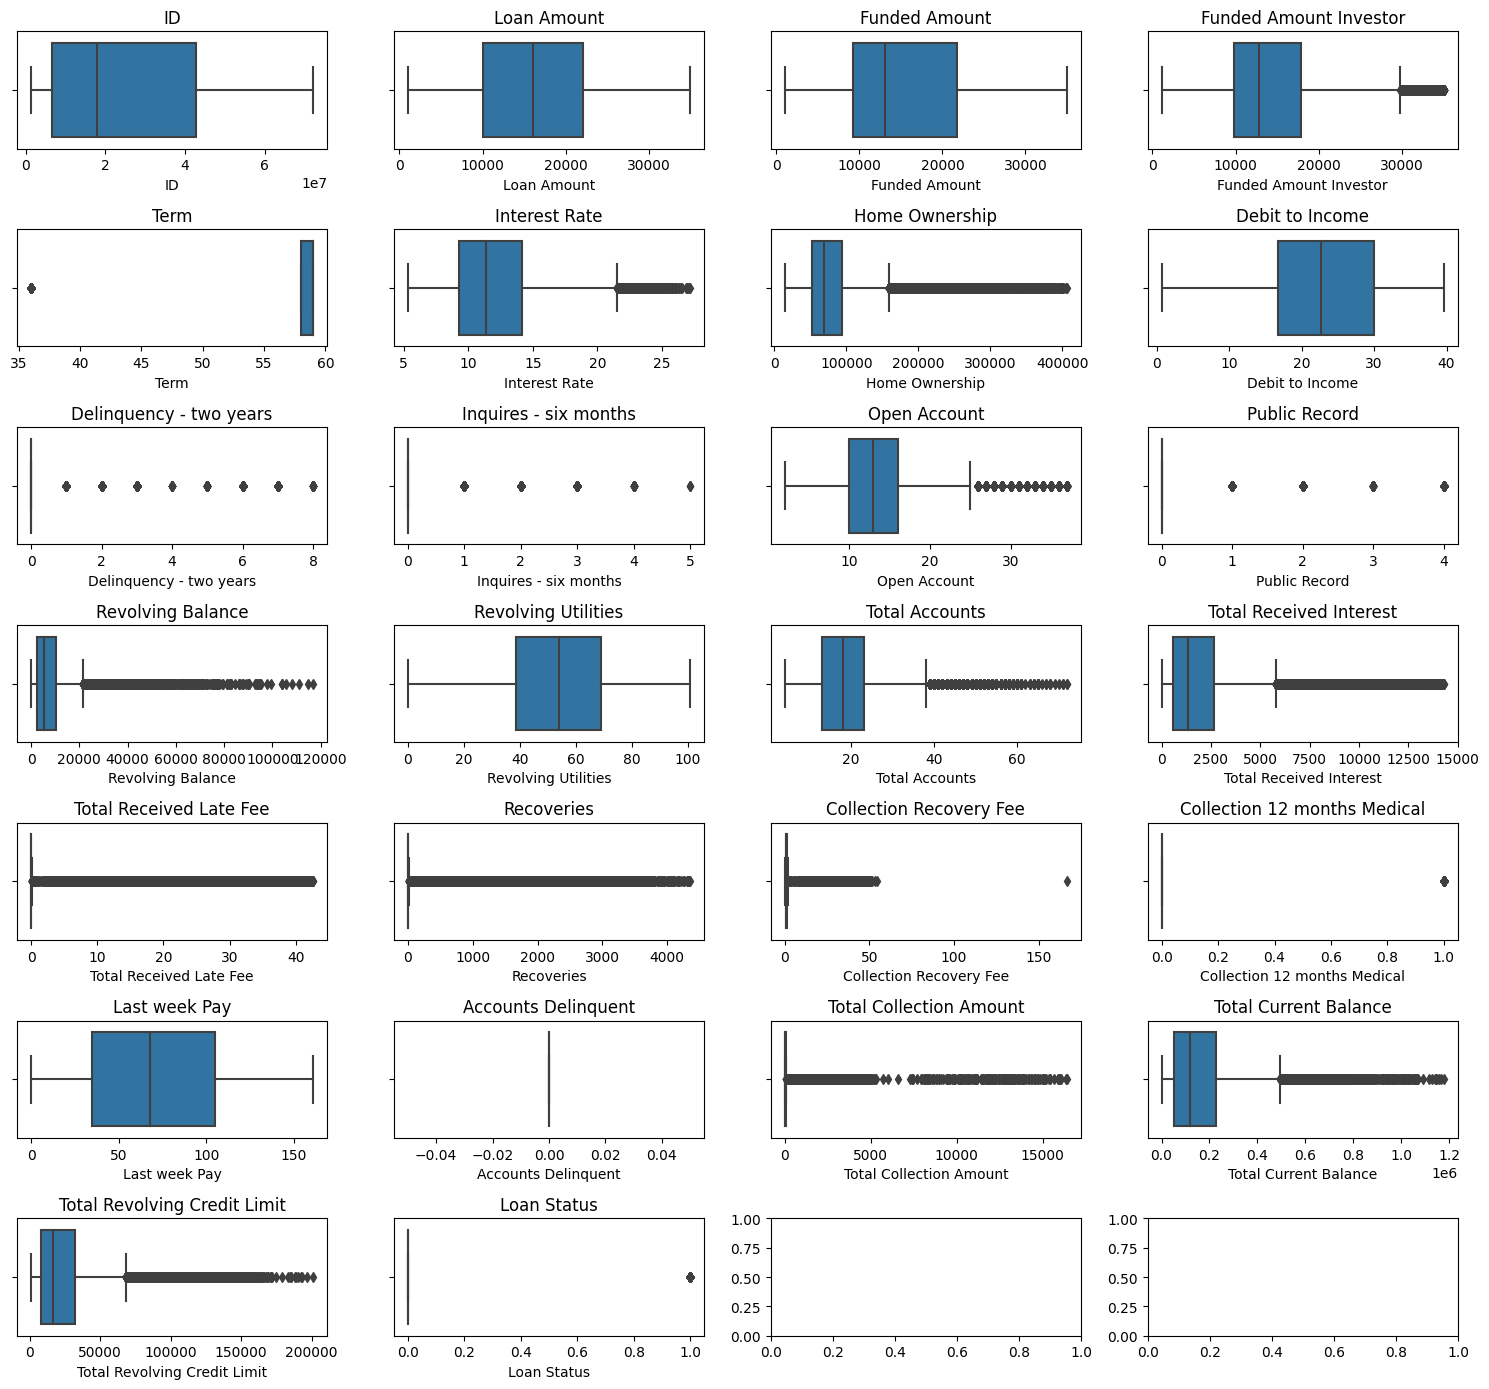

In [6]:
# Box plots for numerical features
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*2))
for i, col in enumerate(numerical_columns):
    sns.boxplot(data=data, x=col, ax=axs[i//n_cols, i%n_cols])
    axs[i//n_cols, i%n_cols].set_title(col)
plt.tight_layout()
plt.show()



In [7]:
# Encoding categorical variables
label_encoders = {}
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

# Separating features and target variable
X = data.drop('Loan Status', axis=1)
y = data['Loan Status']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
from sklearn.metrics import accuracy_score
# XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Measuring training time
start_time = time.time()
xgb.fit(X_train, y_train)
training_time = time.time() - start_time

# Predicting on test set and calculating accuracy
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Training time: {training_time} seconds")
print(f"Accuracy: {accuracy}")


Training time: 3.2152669429779053 seconds
Accuracy: 0.9088416215815608


In [11]:
import numpy as np
def add_noise(X, epsilon):
    """Adds Gaussian noise to the dataset based on epsilon value."""
    sigma = np.sqrt(2 * np.log(1.25 / 0.01)) / epsilon
    noisy_data = X + np.random.normal(0, sigma, X.shape)
    return noisy_data


In [13]:
X_scaled = scaler.fit_transform(X)

# Epsilon values for noise addition
epsilons = [0.5, 1.0, 1.5, 2.0, 3.0, 4.0]

# Record training times and accuracies
results = []

for epsilon in epsilons:
    # Adding noise to the data
    X_noisy = add_noise(X_scaled, epsilon)

    # Splitting noisy data into training and testing sets
    X_train_noisy, X_test_noisy, y_train, y_test = train_test_split(X_noisy, y, test_size=0.2, random_state=42)

    # XGBoost Classifier
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Training the model and measuring training time
    start_time = time.time()
    xgb.fit(X_train_noisy, y_train)
    training_time = time.time() - start_time

    # Predicting on test set and calculating accuracy
    y_pred = xgb.predict(X_test_noisy)
    accuracy = accuracy_score(y_test, y_pred)

    results.append((epsilon, training_time, accuracy))

# Print results
for epsilon, training_time, accuracy in results:
    print(f"Epsilon: {epsilon}, Training Time: {training_time:.2f} seconds, Accuracy: {accuracy:.2f}")


Epsilon: 0.5, Training Time: 1.99 seconds, Accuracy: 0.91
Epsilon: 1.0, Training Time: 1.91 seconds, Accuracy: 0.91
Epsilon: 1.5, Training Time: 1.95 seconds, Accuracy: 0.91
Epsilon: 2.0, Training Time: 1.95 seconds, Accuracy: 0.91
Epsilon: 3.0, Training Time: 4.80 seconds, Accuracy: 0.91
Epsilon: 4.0, Training Time: 6.00 seconds, Accuracy: 0.91
